# COMP4318/5318 Assignment 2: Image Classification

### Group number: A2 group 277, SID1: #######, SID2: ######## (Iftikhar Amiri)

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [ ]:
# Ignore future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools
import scipy.stats as stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import keras_tuner as kt

# Optional: Check GPU availability
print(tf.config.list_physical_devices('GPU'))

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Version Control
import sys
print(f"python version: {sys.version}")
print(f"numpy version: {np.__version__}")
print(f"tensorflow version: {tf.__version__}")
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
print(f"keras version: {keras.__version__}")
print(f"pandas version: {pd.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
!nvidia-smi

python version: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
numpy version: 1.26.4
tensorflow version: 2.10.0
scikit-learn version: 1.6.1
keras version: 2.10.0
pandas version: 2.2.3
matplotlib version: 3.9.4
Mon May 12 14:24:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section. More detail of data preprocessing can look into the algorithm functions and report.

Shape of X_train: (32000, 28, 28, 3)
Shape of y_train: (32000,)
Shape of X_test: (8000, 28, 28, 3)
Shape of y_test: (8000,)
Class range: [0 1 2 3 4 5 6 7 8]
Pixel range: 0 255

Train Set:
       Count   Pct   Tissue
Class                      
1       3490  10.9  Adipose
2       3431  10.7     Back
3       3505  11.0   Debris
4       3656  11.4    Lymph
5       2950   9.2   Mucosa
6       4290  13.4   Muscle
7       2728   8.5   Normal
8       3253  10.2   Stroma
9       4697  14.7    Tumor

Test Set:
       Count   Pct   Tissue
Class                      
1        873  10.9  Adipose
2        858  10.7     Back
3        877  11.0   Debris
4        914  11.4    Lymph
5        737   9.2   Mucosa
6       1072  13.4   Muscle
7        682   8.5   Normal
8        813  10.2   Stroma
9       1174  14.7    Tumor


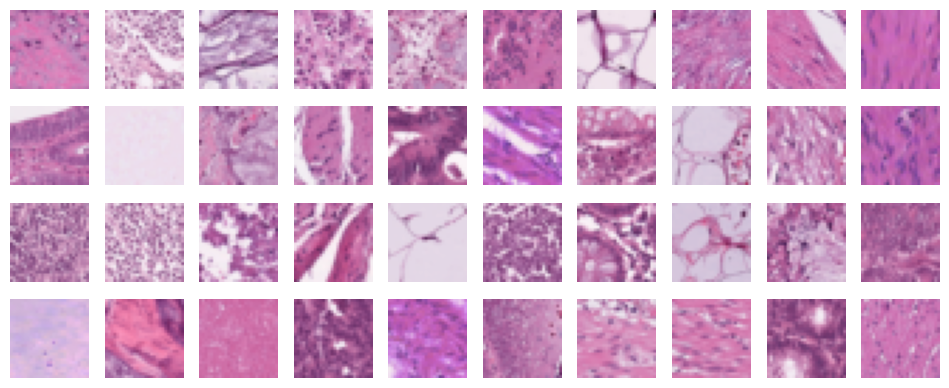

In [ ]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print("Class range:", np.unique(y_train)) # List all unique labels in the training set
print("Pixel range:", X_train.min(), X_train.max()) # 0 - 255

class_names = ['Adipose', 'Back', 'Debris', 'Lymph', 'Mucosa', 'Muscle', 'Normal', 'Stroma', 'Tumor']

# Calculate percentages
def print_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    dist = pd.DataFrame({
        'Class': unique + 1,
        'Count': counts,
        'Pct': (counts / len(y) * 100).round(1)
    })
    dist['Tissue'] = dist['Class'].map(lambda x: class_names[x - 1])
    print(f"\n{title}:\n{dist.set_index('Class')}")


print_distribution(y_train, "Train Set")
print_distribution(y_test, "Test Set")

def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of PathMNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(X_train)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

##### We carefully chosen SVM over RF after PCA variance-based comparision, as SVM outperform RF with higher accuracy.

#### Random Forest

PCA components: 0.95, RF estimators: 100
Test Accuracy: 0.6364

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87       873
           1       0.98      0.91      0.94       858
           2       0.56      0.30      0.39       877
           3       0.77      0.90      0.83       914
           4       0.65      0.56      0.60       737
           5       0.52      0.62      0.57      1072
           6       0.45      0.16      0.24       682
           7       0.50      0.40      0.44       813
           8       0.49      0.76      0.59      1174

    accuracy                           0.64      8000
   macro avg       0.64      0.62      0.61      8000
weighted avg       0.63      0.64      0.62      8000



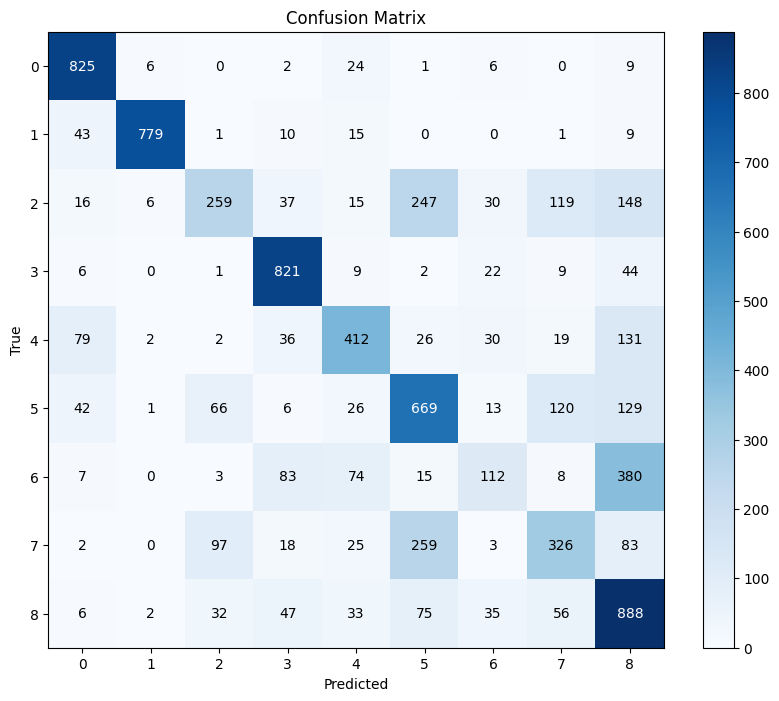

In [ ]:
def run_pca_random_forest_classifier(X_train, y_train, X_test, y_test, 
                                      n_components=0.95, n_estimators=100, verbose=True):
    """
    Arg:
    - X_train, y_train: Training data and labels
    - X_test, y_test: Test data and labels
    - n_components: Number of PCA components to keep
    - n_estimators: Number of trees in Random Forest
    - verbose: Whether to print results
    
    Returns:
    - model: Trained Random Forest classifier
    - y_pred: Predictions on test set
    - acc: Accuracy score
    - cm: Confusion matrix
    """
    # Preprocesing
    # 1. Flatten images
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    # 2. Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_flat)
    X_test_pca = pca.transform(X_test_flat)

    # Fit Random Forest
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train_pca, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    if verbose:
        print(f"PCA components: {n_components}, RF estimators: {n_estimators}")
        print(f"Test Accuracy: {acc:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        # Visualize confusion matrix as a heatmap using matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.colorbar()
        
        # Add class labels
        classes = np.unique(y_test)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        # Add text annotations for each cell
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, cm[i, j], ha='center', va='center', 
                         color='white' if cm[i, j] > cm.max() / 2 else 'black')

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return rf, y_pred, acc, cm

rf_model, rf_preds, rf_acc, rf_cm = run_pca_random_forest_classifier(X_train, y_train, X_test, y_test)

#### SVM

PCA components: 0.95, SVM kernel: rbf, C: 1.0, gamma: scale
Test Accuracy: 0.6617

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89       873
           1       0.96      0.88      0.92       858
           2       0.47      0.30      0.37       877
           3       0.91      0.85      0.88       914
           4       0.58      0.58      0.58       737
           5       0.64      0.68      0.66      1072
           6       0.45      0.25      0.32       682
           7       0.48      0.53      0.51       813
           8       0.55      0.78      0.64      1174

    accuracy                           0.66      8000
   macro avg       0.65      0.64      0.64      8000
weighted avg       0.66      0.66      0.65      8000



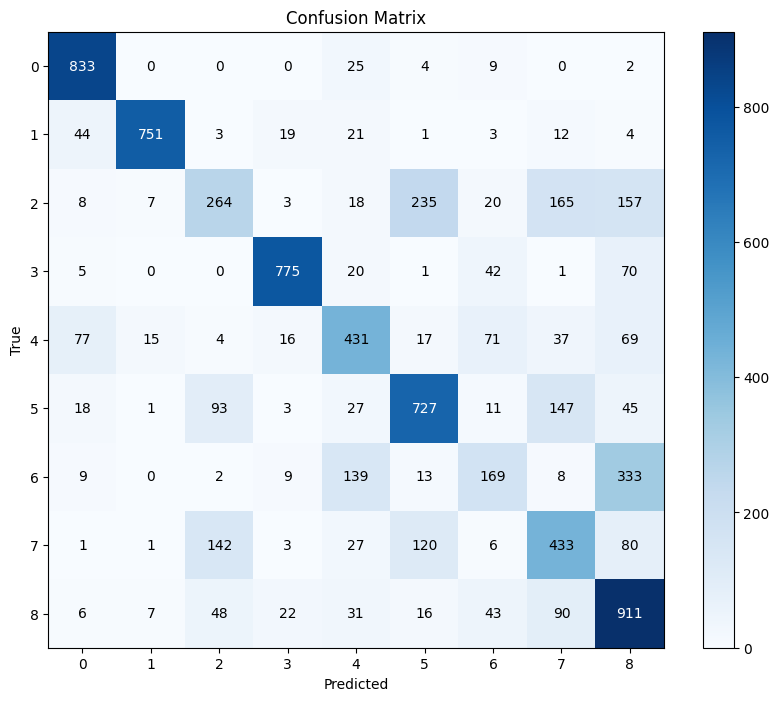

In [ ]:
def run_pca_svm_classifier(X_train, y_train, X_test, y_test, 
                            n_components=0.95, kernel='rbf', C=1.0, gamma='scale', verbose=True):
    """
    Arg:
    - X_train, y_train: Training data and labels
    - X_test, y_test: Test data and labels
    - n_components: Number of PCA components to keep
    - kernel: Kernel type ('linear', 'rbf', etc.)
    - C: Regularization parameter
    - gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    - verbose: Whether to print results
    
    Returns:
    - model: Trained SVM classifier
    - y_pred: Predictions on test set
    - acc: Accuracy score
    """
    # Preprocesing
    # 1. Flatten images
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    # 2. Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_flat)
    X_test_pca = pca.transform(X_test_flat)

    # Fit SVM
    svm = SVC(kernel=kernel, C=C, gamma=gamma)
    svm.fit(X_train_pca, y_train)

    # Predict and evaluate
    y_pred = svm.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    if verbose:
        print(f"PCA components: {n_components}, SVM kernel: {kernel}, C: {C}, gamma: {gamma}")
        print(f"Test Accuracy: {acc:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        # Visualize confusion matrix as a heatmap using matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.colorbar()
        
        # Add class labels
        classes = np.unique(y_test)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        # Add text annotations for each cell
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, cm[i, j], ha='center', va='center', 
                         color='white' if cm[i, j] > cm.max() / 2 else 'black')

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return svm, y_pred, acc

svm_model, svm_preds, svm_acc = run_pca_svm_classifier(X_train, y_train, X_test, y_test)

### Fully connected neural network

Flattened shapes - Train: (32000, 2352), Test: (8000, 2352)
Standardization complete
PCA reduced dimensions to 343 components
Number of classes: 9

Creating and training the model...
Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 1.3267 - accuracy: 0.5195 - val_loss: 1.1577 - val_accuracy: 0.5754 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 0s 3ms/step - loss: 0.9661 - accuracy: 0.6384 - val_loss: 0.9317 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 0s 4ms/step - loss: 0.8432 - accuracy: 0.6883 - val_loss: 0.8898 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 0.7169 - val_loss: 0.8671 - val_accuracy: 0.6811 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.7489 - val_loss: 0.8662 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 6/50
125/125 [======================

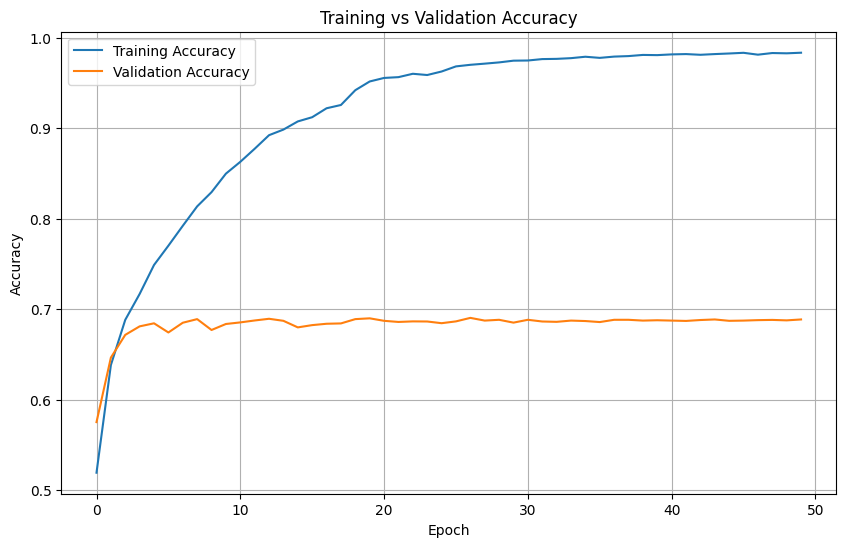


==== Final Results ====
Test Accuracy: 0.6886
Model Architecture:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               176128    
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                     

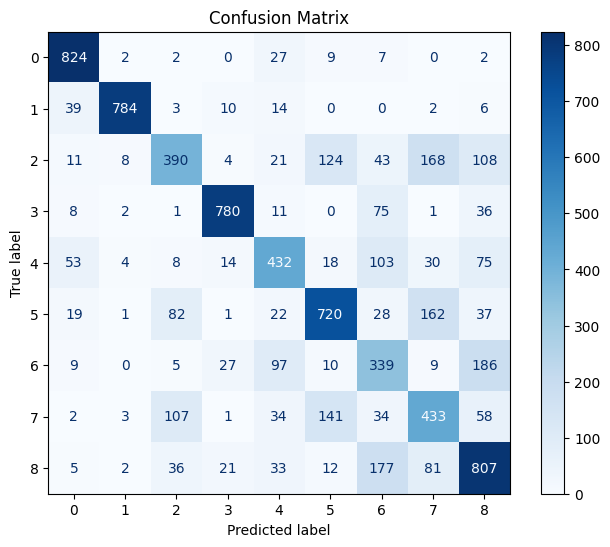

In [ ]:
def create_model(input_dim, num_classes, hidden_dims=[512, 256], dropout_rate=0.2, learning_rate=0.001):
    """
    Function to create a Keras model with the specified hyperparameters
    """
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_dims[0], activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for dim in hidden_dims[1:]:
        model.add(Dense(dim, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid'))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    loss = 'categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_cm():
    # Compute the confusion matrix
    y_pred = model.predict(pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1))))
    num_classes = len(np.unique(y_test))
    y_pred_classes = np.argmax(y_pred, axis=1) if num_classes > 2 else (y_pred > 0.5).astype(int).flatten()

    cm = confusion_matrix(y_test, y_pred_classes)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=True)
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

def mlp_pipeline(X_train, y_train, X_test, y_test,
               pca_variance=0.95,
               hidden_dims=[512, 256],
               dropout_rate=0.2,
               learning_rate=0.001,
               batch_size=256,
               epochs=50,
               verbose=True):
    """
    Args:
    - X_train, y_train: Training data
    - X_test, y_test: Test data
    - pca_variance: Variance to retain in PCA
    - hidden_dims: List of hidden layer dimensions
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for optimizer
    - batch_size: Batch size for training
    - epochs: Number of epochs to train
    - verbose: Whether to print progress information
        
    Returns:
        tuple: (model, pca, scaler, test_accuracy, timings_dict)
    """  
    timings = {}
    start_total = time.time()

    # Preprocesing
    # 1. Flatten images
    start = time.time()
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    timings['flattening'] = time.time() - start
    
    if verbose:
        print(f"Flattened shapes - Train: {X_train_flat.shape}, Test: {X_test_flat.shape}")

    # 2. Standardize
    start = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    timings['standardization'] = time.time() - start
    
    if verbose:
        print("Standardization complete")

    # 3. PCA
    start = time.time()
    pca = PCA(pca_variance)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    timings['pca'] = time.time() - start
    
    input_dim = X_train_pca.shape[1]
    num_classes = len(np.unique(y_train))
    
    if verbose:
        print(f"PCA reduced dimensions to {input_dim} components")
        print(f"Number of classes: {num_classes}")

    # Convert labels to one-hot encoding if needed
    if num_classes > 2:
        y_train_cat = np.eye(num_classes)[y_train]
        y_test_cat = np.eye(num_classes)[y_test]
    else:
        y_train_cat = y_train
        y_test_cat = y_test
    
    # 4. Create and train the model with specified parameters
    if verbose:
        print("\nCreating and training the model...")
    
    start = time.time()
    model = create_model(
        input_dim=input_dim,
        num_classes=num_classes,
        hidden_dims=hidden_dims,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    
    # Callbacks for training
    callbacks = [ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        verbose=verbose,
        mode='max'
    )]
    
    # Train the model
    history = model.fit(
        X_train_pca, y_train_cat,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test_pca, y_test_cat),
        callbacks=callbacks,
        verbose=1 if verbose else 0
    )
    
    timings['training'] = time.time() - start

    # 5. Evaluate model
    start = time.time()
    y_pred = model.predict(X_test_pca)
    y_pred_classes = np.argmax(y_pred, axis=1) if num_classes > 2 else (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    timings['prediction'] = time.time() - start
    
    # Total time
    timings['total'] = time.time() - start_total

    if verbose:
        print(f"\nTest Accuracy: {accuracy:.4f}")
        print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
        print("\nTime measurements (seconds):")
        for stage, t in timings.items():
            print(f"- {stage}: {t:.2f}s")
    
    return model, pca, scaler, accuracy, timings, history

# Example usage
model, pca, scaler, test_accuracy, timings, history = mlp_pipeline(
    X_train, y_train, X_test, y_test,
    pca_variance=0.95,
    hidden_dims=[512, 256],
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=256,
    epochs=50,
    verbose=True
)

plot_training_history(history)

# Print the final results
print("\n==== Final Results ====")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Model Architecture:")
model.summary()
print("\nTotal time: {:.2f}s".format(timings['total']))
plot_cm()

### Convolutional neural network

Epoch 1/30
125/125 [==============================] - 3s 13ms/step - loss: 1.1861 - accuracy: 0.5969 - val_loss: 3.4479 - val_accuracy: 0.1710 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - 1s 10ms/step - loss: 0.6676 - accuracy: 0.7607 - val_loss: 10.4175 - val_accuracy: 0.1080 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - 1s 10ms/step - loss: 0.5384 - accuracy: 0.8050 - val_loss: 16.8172 - val_accuracy: 0.1075 - lr: 0.0010
Epoch 4/30
125/125 [==============================] - 1s 8ms/step - loss: 0.4386 - accuracy: 0.8441 - val_loss: 4.7501 - val_accuracy: 0.2695 - lr: 0.0010
Epoch 5/30
125/125 [==============================] - 1s 9ms/step - loss: 0.3754 - accuracy: 0.8669 - val_loss: 2.8262 - val_accuracy: 0.4701 - lr: 0.0010
Epoch 6/30
125/125 [==============================] - 1s 11ms/step - loss: 0.3241 - accuracy: 0.8867 - val_loss: 0.4736 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 7/30
125/125 [==============================] - 1s 10ms/st

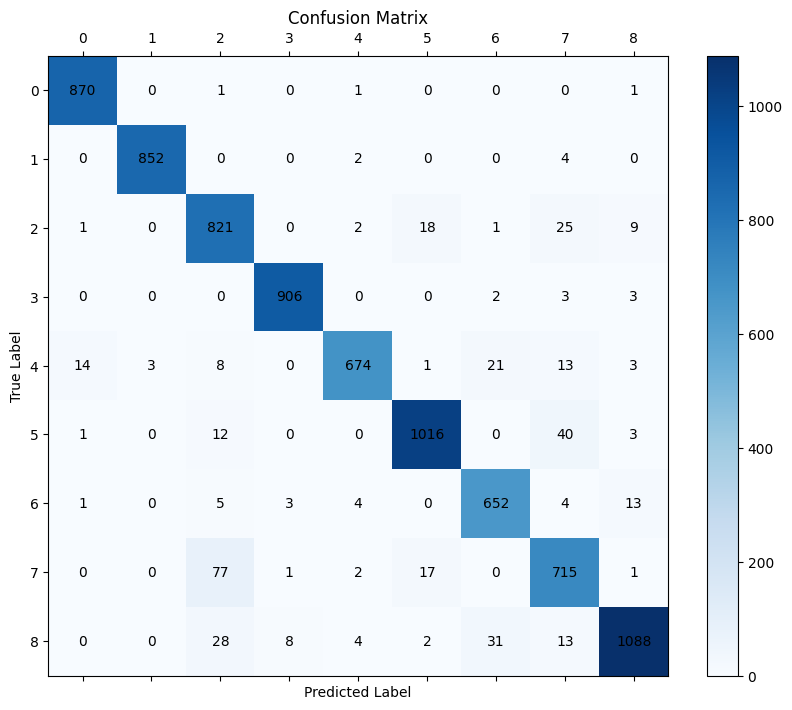

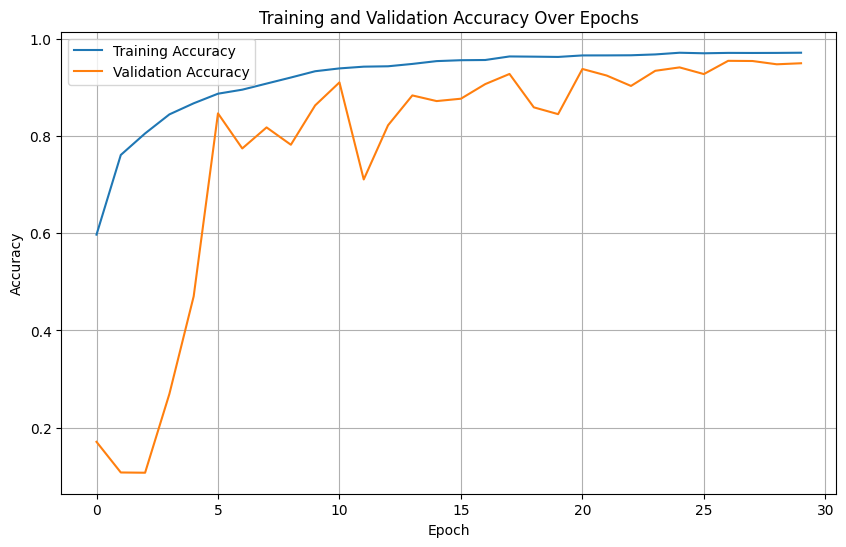


Final Test Accuracy: 0.9493
Best Val Accuracy: 0.9542

Time measurements (seconds):
- training: 35.01s
- prediction: 0.63s
- total: 39.64s
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_180 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_76 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_181 (Ba  (None, 28, 28, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 14, 14, 

In [ ]:
def cnn_pipeline(X_train, y_train, X_test, y_test,
                 input_shape=(28, 28, 3),  # Adjust based on your image dimensions
                 batch_size=128,
                 epochs=30,
                 verbose=True):
    """
    Returns:
    tuple: (trained model, test accuracy, timings_dict)
    """
    timings = {}
    start_total = time.time()
    
    num_classes = len(np.unique(y_train))
    
    # Convert labels to one-hot if needed
    if num_classes > 2:
        y_train_cat = np.eye(num_classes)[y_train]
        y_test_cat = np.eye(num_classes)[y_test]
    else:
        y_train_cat = y_train
        y_test_cat = y_test

    # Build CNN model
    model = Sequential()
    
    # Feature extraction
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Classification head
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    callbacks = [ReduceLROnPlateau(monitor='val_accuracy', 
                                   factor=0.5,
                                   patience=3,
                                   verbose=verbose,
                                   mode='max')]

    # Train model
    start = time.time()
    history = model.fit(X_train, y_train_cat,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(X_test, y_test_cat),
                       callbacks=callbacks,
                       verbose=1 if verbose else 0)
    timings['training'] = time.time() - start

    # Evaluate
    start = time.time()
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1) if num_classes > 2 else (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    timings['prediction'] = time.time() - start
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    if verbose:
        # Visualize Confusion Matrix with Matplotlib
        plt.figure(figsize=(10, 8))
        plt.matshow(cm, cmap='Blues', fignum=1)
        plt.colorbar()
        
        # Add annotations (numbers in each cell)
        for i in range(num_classes):
            for j in range(num_classes):
                plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
        
        # Add labels and title
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.xticks(range(num_classes))
        plt.yticks(range(num_classes))
        plt.show()

        # Plot Training and Validation Accuracy
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Total time
    timings['total'] = time.time() - start_total

    if verbose:
        print(f"\nFinal Test Accuracy: {accuracy:.4f}")
        print(f"Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")
        print("\nTime measurements (seconds):")
        for stage, t in timings.items():
            print(f"- {stage}: {t:.2f}s")

    return model, accuracy, timings

cnn_model, cnn_acc, cnn_timings = cnn_pipeline(
    X_train, y_train, X_test, y_test,
    input_shape=X_train.shape[1:],  # Automatically use correct input shape
    batch_size=256,
    epochs=30,
    verbose=True
)

cnn_model.summary()

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

#### SVM

Best Parameters from GridSearchCV: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy: 0.6856
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       873
           1       0.95      0.89      0.92       858
           2       0.47      0.37      0.41       877
           3       0.91      0.92      0.91       914
           4       0.66      0.64      0.65       737
           5       0.66      0.65      0.65      1072
           6       0.52      0.43      0.47       682
           7       0.50      0.57      0.53       813
           8       0.58      0.68      0.63      1174

    accuracy                           0.69      8000
   macro avg       0.68      0.68      0.68      8000
weighted avg       0.68      0.69      0.68      8000



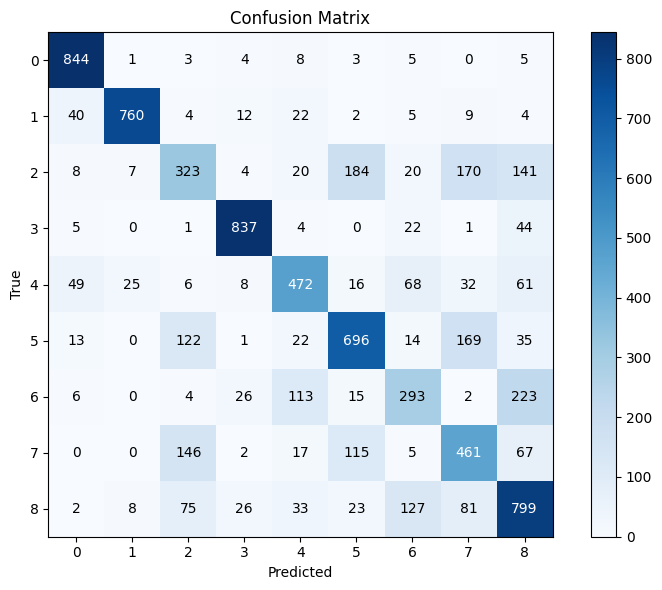


--- Timing Report ---
PCA fitting & transform:      0.20 seconds
SVM training/tuning:          7.92 seconds
Final training on full set:   15.65 seconds
Prediction & evaluation:      8.78 seconds
Total pipeline time:          32.69 seconds


In [ ]:
def ht_pca_svm(X_train, y_train, X_test, y_test, 
                  n_components=30, sample_frac=0.2, tune=False, verbose=True):
    """
    Returns:
    - model: Trained SVM classifier
    - y_pred: Predictions on test set
    - acc: Accuracy score
    - best_params: Best hyperparameters if tune=True, else None
    """
    start_total = time.time()

    # Flatten images
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    # Subsampling
    X_sub, _, y_sub, _ = train_test_split(X_train_flat, y_train, 
                                          train_size=sample_frac, stratify=y_train, random_state=42)

    # PCA
    start_pca = time.time()
    pca = PCA(n_components=n_components)
    X_sub_pca = pca.fit_transform(X_sub)
    X_test_pca = pca.transform(X_test_flat)
    end_pca = time.time()

    best_params = None  # Default if not tuning

    # Fit or tune SVM
    start_train = time.time()
    if tune:
        param_grid = {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.01],
            'kernel': ['rbf', 'linear']
        }
        clf = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1, verbose=0)
        clf.fit(X_sub_pca, y_sub)
        model = clf.best_estimator_
        best_params = clf.best_params_
        if verbose:
            print("Best Parameters from GridSearchCV:", best_params)
    else:
        model = SVC(kernel='rbf', C=1.0, gamma='scale')
        model.fit(X_sub_pca, y_sub)
    end_train = time.time()

    # Final model training
    start_final_train = time.time()
    X_full_pca = pca.transform(X_train_flat)
    model.fit(X_full_pca, y_train)
    end_final_train = time.time()

    # Prediction
    start_pred = time.time()
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    end_pred = time.time()

    end_total = time.time()

    if verbose:
        print(f"\nAccuracy: {acc:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.colorbar()
        ticks = np.arange(len(np.unique(y_test)))
        plt.xticks(ticks, ticks)
        plt.yticks(ticks, ticks)
        for i in range(len(ticks)):
            for j in range(len(ticks)):
                plt.text(j, i, cm[i, j], ha='center', va='center',
                         color='white' if cm[i, j] > cm.max() / 2 else 'black')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        print("\n--- Timing Report ---")
        print(f"PCA fitting & transform:      {end_pca - start_pca:.2f} seconds")
        print(f"SVM training/tuning:          {end_train - start_train:.2f} seconds")
        print(f"Final training on full set:   {end_final_train - start_final_train:.2f} seconds")
        print(f"Prediction & evaluation:      {end_pred - start_pred:.2f} seconds")
        print(f"Total pipeline time:          {end_total - start_total:.2f} seconds")

    return model, y_pred, acc, best_params

model, preds, acc, best_params = ht_pca_svm(
    X_train, y_train, X_test, y_test,
    n_components=30, sample_frac=0.2, tune=True
)

### Fully connected neural network

Flattened shapes - Train: (32000, 2352), Test: (8000, 2352)
Standardization complete
PCA reduced dimensions to 343 components
Number of classes: 9
Setting up hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\willi\AppData\Local\Temp\ipykernel_8548\2732988302.py:123: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


[CV] END batch_size=512, dropout_rate=0.4186171947440932, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.0036256176345762273; total time=   2.0s
[CV] END batch_size=512, dropout_rate=0.4186171947440932, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.0036256176345762273; total time=   1.9s
[CV] END batch_size=512, dropout_rate=0.4186171947440932, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.0036256176345762273; total time=   2.2s
[CV] END batch_size=128, dropout_rate=0.1624074561769746, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.00015847101210439104; total time=   5.7s
[CV] END batch_size=128, dropout_rate=0.1624074561769746, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.00015847101210439104; total time=   5.4s
[CV] END batch_size=128, dropout_rate=0.1624074561769746, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.00015847101210439104; total time=   5.9s
[CV] END batch_size=512, dropout_rate=0.4464704583099741, epochs=10

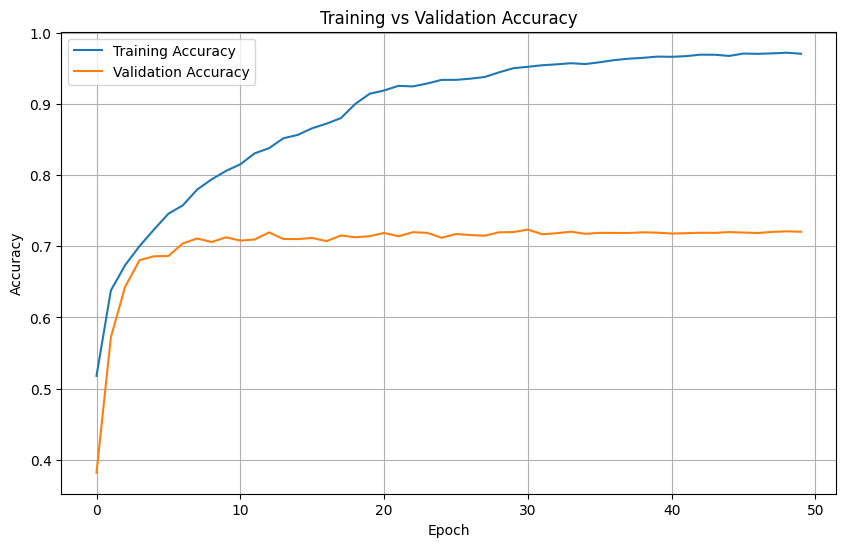


==== Final Results ====
Test Accuracy: 0.7202

Best Hyperparameters:
- batch_size: 512
- dropout_rate: 0.4186171947440932
- epochs: 10
- hidden_dims: [1024, 512, 256]
- learning_rate: 0.0036256176345762273

Total time: 103.60s


In [ ]:
def create_model(input_dim, num_classes, hidden_dims=[512, 256], dropout_rate=0.2, learning_rate=0.001):
    """
    Function to create a Keras model with the specified hyperparameters
    """
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_dims[0], activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for dim in hidden_dims[1:]:
        model.add(Dense(dim, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid'))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    loss = 'categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy'
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

def ht_mlp_pipeline(X_train, y_train, X_test, y_test,
                            pca_variance=0.95,
                            tuning_iterations=20,
                            cv_folds=3,
                            final_training_epochs=50,
                            verbose=True):
    """
    Args:
    - X_train, y_train: Training data
    - X_test, y_test: Test data
    - pca_variance: Variance to retain in PCA
    - tuning_iterations: Number of parameter settings to try in RandomizedSearchCV
    - cv_folds: Number of cross-validation folds
    - final_training_epochs: Number of epochs to train the final model
    - verbose: Whether to print progress information
        
    Returns:
    - tuple: (best_model, pca, scaler, test_accuracy, timings_dict, best_params)
    """
    timings = {}
    start_total = time.time()
    
    # 1. Flatten images
    start = time.time()
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    timings['flattening'] = time.time() - start
    
    if verbose:
        print(f"Flattened shapes - Train: {X_train_flat.shape}, Test: {X_test_flat.shape}")

    # 2. Standardize
    start = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    timings['standardization'] = time.time() - start
    
    if verbose:
        print("Standardization complete")

    # 3. PCA
    start = time.time()
    pca = PCA(pca_variance)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    timings['pca'] = time.time() - start
    
    input_dim = X_train_pca.shape[1]
    num_classes = len(np.unique(y_train))
    
    if verbose:
        print(f"PCA reduced dimensions to {input_dim} components")
        print(f"Number of classes: {num_classes}")

    # Convert labels to one-hot encoding if needed
    if num_classes > 2:
        y_train_cat = np.eye(num_classes)[y_train]
        y_test_cat = np.eye(num_classes)[y_test]
    else:
        y_train_cat = y_train
        y_test_cat = y_test
    
    # 4. Define hyperparameter search space
    if verbose:
        print("Setting up hyperparameter tuning...")
    
    # Define the parameter grid for hyperparameter search
    param_dist = {
        'hidden_dims': [
            [512, 256],
            [1024, 512],
            [1024, 512, 256],
            [2048, 1024, 512],
            [1024, 1024, 512, 256]
        ],
        'dropout_rate': stats.uniform(0.1, 0.4),  # Uniform distribution between 0.1 and 0.5
        'learning_rate': stats.loguniform(1e-4, 1e-2),  # Log-uniform between 0.0001 and 0.01
        'batch_size': [128, 256, 512, 1024],
        'epochs': [10]  # Use fewer epochs during hyperparameter search
    }
    
    # Create the model function for KerasClassifier
    def create_model_wrapper(hidden_dims, dropout_rate, learning_rate):
        return create_model(
            input_dim=input_dim,
            num_classes=num_classes,
            hidden_dims=hidden_dims,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate
        )
    
    # Wrap Keras model in scikit-learn compatible classifier
    model = KerasClassifier(
        build_fn=create_model_wrapper,
        verbose=0
    )
    
    # 5. Perform hyperparameter tuning
    start = time.time()
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=tuning_iterations,
        cv=cv_folds,
        verbose=2 if verbose else 0,
        random_state=42,
        n_jobs=1
    )
    
    search_result = search.fit(X_train_pca, y_train)
    timings['hyperparameter_tuning'] = time.time() - start
    
    best_params = search_result.best_params_
    
    if verbose:
        print("\nBest Hyperparameters:")
        for param, value in best_params.items():
            print(f"- {param}: {value}")
    
    # 6. Train final model with best parameters
    if verbose:
        print("\nTraining final model with best hyperparameters...")
    
    # Create and train the final model
    start = time.time()
    final_model = create_model(
        input_dim=input_dim,
        num_classes=num_classes,
        hidden_dims=best_params['hidden_dims'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )
    
    # Callbacks for final model
    callbacks = [ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        verbose=verbose,
        mode='max'
    )]
    
    # Train final model with more epochs
    history = final_model.fit(
        X_train_pca, y_train_cat,
        batch_size=best_params['batch_size'],
        epochs=final_training_epochs,
        validation_data=(X_test_pca, y_test_cat),
        callbacks=callbacks,
        verbose=1 if verbose else 0
    )
    
    timings['final_training'] = time.time() - start
    
    # 7. Evaluate final model
    start = time.time()
    y_pred = final_model.predict(X_test_pca)
    y_pred_classes = np.argmax(y_pred, axis=1) if num_classes > 2 else (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    timings['prediction'] = time.time() - start
    
    # Total time
    timings['total'] = time.time() - start_total
    
    if verbose:
        print(f"\nFinal Test Accuracy: {accuracy:.4f}")
        print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
        print("\nTime measurements (seconds):")
        for stage, t in timings.items():
            print(f"- {stage}: {t:.2f}s")
    
    return final_model, pca, scaler, accuracy, timings, best_params, history

tuned_model, pca, scaler, test_accuracy, timings, best_params, history = ht_mlp_pipeline(
    X_train, y_train, X_test, y_test,
    pca_variance=0.95,
    tuning_iterations=10,  # Reduced for demonstration, increase for better results
    cv_folds=3,
    final_training_epochs=50,
    verbose=True
)

plot_training_history(history)

# Print the final results
print("\n==== Final Results ====")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"- {param}: {value}")
print("\nTotal time: {:.2f}s".format(timings['total']))

### Convolutional neural network

Testing: lr=0.0001, dropout=0.3, filters=32, extra_conv_block=True
Testing: lr=0.0001, dropout=0.3, filters=32, extra_conv_block=False
Testing: lr=0.0001, dropout=0.3, filters=64, extra_conv_block=True
Testing: lr=0.0001, dropout=0.3, filters=64, extra_conv_block=False
Testing: lr=0.0001, dropout=0.4, filters=32, extra_conv_block=True
Testing: lr=0.0001, dropout=0.4, filters=32, extra_conv_block=False
Testing: lr=0.0001, dropout=0.4, filters=64, extra_conv_block=True
Testing: lr=0.0001, dropout=0.4, filters=64, extra_conv_block=False
Testing: lr=0.0005, dropout=0.3, filters=32, extra_conv_block=True
Testing: lr=0.0005, dropout=0.3, filters=32, extra_conv_block=False

Best Hyperparameters:
- Learning Rate: 0.0005
- Dropout Rate: 0.3
- Filters: 32
- Extra Conv Block: False

Epoch 1/50
125/125 [==============================] - 2s 12ms/step - loss: 2.2558 - accuracy: 0.5207 - val_loss: 5.8821 - val_accuracy: 0.1072 - lr: 5.0000e-04
Epoch 2/50
125/125 [==============================] - 1s 

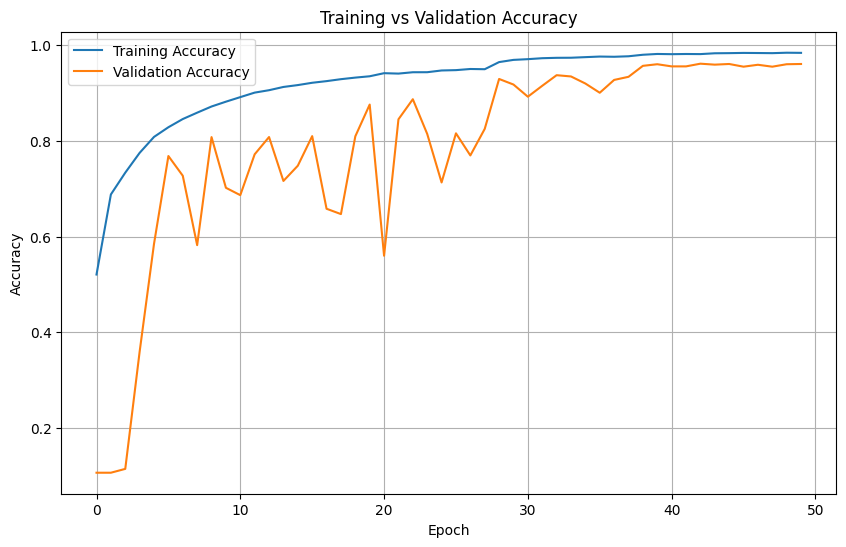

Final Training Accuracy: 0.9831
Final Validation Accuracy: 0.9599
250/250 [==============================] - 0s 1ms/step
CNN Test Accuracy: 0.9599


In [ ]:
# Enable mixed precision training for RTX 4090
mixed_precision.set_global_policy('mixed_float16')

# Reshape inputs if needed
if len(X_train.shape) == 3:  # if grayscale
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
else:
    X_train_cnn = X_train
    X_test_cnn = X_test

def build_model(learning_rate, dropout_rate, filters, extra_conv_block):
    model = tf.keras.Sequential([
        # First Conv Block
        Conv2D(filters, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001),
               input_shape=X_train_cnn.shape[1:]),
        BatchNormalization(),
        Conv2D(filters, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        
        # Second Conv Block
        Conv2D(filters*2, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(filters*2, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate + 0.1),  # Slightly higher dropout as in original
        
        # Third Conv Block
        Conv2D(filters*4, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(filters*4, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate + 0.2),
        
        # Optional Fourth Conv Block for RTX 4090 capacity
        *([Conv2D(filters*8, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
           BatchNormalization(),
           MaxPooling2D((2, 2)),
           Dropout(dropout_rate + 0.2)] if extra_conv_block else []),
        
        # Flatten and Dense
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),
              dtype='float32'),  # Ensure float32 for stability
        BatchNormalization(),
        Dropout(dropout_rate + 0.2),
        
        # Output layer
        Dense(9, activation='softmax', dtype='float32')
    ])
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Define hyperparameter
learning_rates = [1e-4, 5e-4, 1e-3]
dropout_rates = [0.3, 0.4]
filters_list = [32, 64]
extra_conv_blocks = [True, False]

# Configure data prefetching for GPU efficiency
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train)).batch(256).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test)).batch(256).prefetch(tf.data.AUTOTUNE)

# Manual grid search (limited to 10 trials)
combinations = list(itertools.product(learning_rates, dropout_rates, filters_list, extra_conv_blocks))
combinations = combinations[:10]  # Limit to 10 trials
best_val_accuracy = 0
best_hps = None

for lr, dr, filters, extra_block in combinations:
    print(f"Testing: lr={lr}, dropout={dr}, filters={filters}, extra_conv_block={extra_block}")
    model = build_model(lr, dr, filters, extra_block)
    history = model.fit(
        train_dataset,
        epochs=30,  # Shorter epochs for tuning
        validation_data=test_dataset,
        callbacks=[
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
        ],
        verbose=0
    )
    val_accuracy = max(history.history['val_accuracy'])
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_hps = {'learning_rate': lr, 'dropout_rate': dr, 'filters': filters, 'extra_conv_block': extra_block}

# Print best hyperparameters
print(f"""
Best Hyperparameters:
- Learning Rate: {best_hps['learning_rate']}
- Dropout Rate: {best_hps['dropout_rate']}
- Filters: {best_hps['filters']}
- Extra Conv Block: {best_hps['extra_conv_block']}
""")

# Train final model with best hyperparameters
model = build_model(
    best_hps['learning_rate'],
    best_hps['dropout_rate'],
    best_hps['filters'],
    best_hps['extra_conv_block']
)
history = model.fit(
    train_dataset,
    epochs=50,  # Full training
    validation_data=test_dataset,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ],
    verbose=1
)

plot_training_history(history)

# Print final training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Evaluate on test set
y_pred_cnn = model.predict(X_test_cnn).argmax(axis=1)
print(f"CNN Test Accuracy: {accuracy_score(y_test, y_pred_cnn):.4f}")

### 10 Trials and summary

In [ ]:
# Enable mixed precision training for RTX 4090
mixed_precision.set_global_policy('mixed_float16')

def build_model(hp):
    model = tf.keras.Sequential()
    
    # Hyperparameter 1: Learning rate
    lr = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3])
    
    # Hyperparameter 2: Dropout rate
    dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5])
    
    # Hyperparameter 3: Number of filters
    filters = hp.Choice('filters', values=[32, 64, 128])
    
    # Architecture optimized for GPU
    model.add(Conv2D(filters, (3,3), activation='relu', padding='same', input_shape=X_train_cnn.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv2D(filters*2, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', dtype='float32'))  # Ensure float32 for dense layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(9, activation='softmax', dtype='float32'))  # Ensure float32 for output
    
    # Compile with tuned learning rate and GPU-optimized optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Test 10 hyperparameter combinations
    directory='tuner_results',
    project_name='pathmnist_cnn'
)

# Convert data to tf.data.Dataset for better GPU utilization
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test)).batch(128).prefetch(tf.data.AUTOTUNE)

# Run search
tuner.search(
    train_dataset,
    epochs=30,  # Shorter epochs for quick tuning
    validation_data=test_dataset,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)]
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
Best Hyperparameters:
- Learning Rate: {best_hps.get('learning_rate')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Filters: {best_hps.get('filters')}
""")

# Train final model with best HPs
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_dataset,
    epochs=100,  # Full training with best HPs
    validation_data=test_dataset,
    callbacks=[EarlyStopping(patience=10)]
)

# Clean up mixed precision policy
mixed_precision.set_global_policy('float32')

Trial 10 Complete [00h 00m 39s]
val_accuracy: 0.7889999747276306

Best val_accuracy So Far: 0.8769999742507935
Total elapsed time: 00h 04m 19s

Best Hyperparameters:
- Learning Rate: 0.0001
- Dropout Rate: 0.3
- Filters: 128

Epoch 1/100
250/250 [==============================] - 2s 8ms/step - loss: 1.3254 - accuracy: 0.5223 - val_loss: 4.6760 - val_accuracy: 0.1072
Epoch 2/100
250/250 [==============================] - 2s 7ms/step - loss: 0.9760 - accuracy: 0.6427 - val_loss: 3.3663 - val_accuracy: 0.3629
Epoch 3/100
250/250 [==============================] - 2s 7ms/step - loss: 0.8499 - accuracy: 0.6946 - val_loss: 1.8315 - val_accuracy: 0.5685
Epoch 4/100
250/250 [==============================] - 2s 7ms/step - loss: 0.7828 - accuracy: 0.7193 - val_loss: 1.1354 - val_accuracy: 0.6446
Epoch 5/100
250/250 [==============================] - 2s 7ms/step - loss: 0.7234 - accuracy: 0.7389 - val_loss: 1.7821 - val_accuracy: 0.5968
Epoch 6/100
250/250 [==============================] - 2s 7

In [ ]:
tuner.results_summary()

Results summary
Results in tuner_results\pathmnist_cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
learning_rate: 0.0001
dropout_rate: 0.4
filters: 128
Score: 0.8199999928474426

Trial 00 summary
Hyperparameters:
learning_rate: 0.0005
dropout_rate: 0.3
filters: 32
Score: 0.7911249995231628

Trial 01 summary
Hyperparameters:
learning_rate: 0.0005
dropout_rate: 0.5
filters: 64
Score: 0.7476249933242798

Trial 03 summary
Hyperparameters:
learning_rate: 0.001
dropout_rate: 0.4
filters: 64
Score: 0.7335000038146973

Trial 09 summary
Hyperparameters:
learning_rate: 0.001
dropout_rate: 0.5
filters: 64
Score: 0.6821249723434448

Trial 04 summary
Hyperparameters:
learning_rate: 0.0005
dropout_rate: 0.4
filters: 128
Score: 0.675125002861023

Trial 05 summary
Hyperparameters:
learning_rate: 0.0005
dropout_rate: 0.3
filters: 128
Score: 0.6618750095367432

Trial 02 summary
Hyperparameters:
learning_rate: 0.0001
dropout_rate: 0.5
filters:

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course


Training SVM_1 with params: {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'}
SVM_1 Test Accuracy: 0.6811
Training Time: 9.34s
Inference Time: 7.12s
Number of Support Vectors: 20206

Classification Report for SVM_1:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       873
           1       0.93      0.89      0.91       858
           2       0.50      0.37      0.43       877
           3       0.91      0.90      0.90       914
           4       0.69      0.63      0.66       737
           5       0.65      0.67      0.66      1072
           6       0.49      0.34      0.40       682
           7       0.49      0.54      0.52       813
           8       0.56      0.72      0.63      1174

    accuracy                           0.68      8000
   macro avg       0.68      0.67      0.67      8000
weighted avg       0.68      0.68      0.67      8000



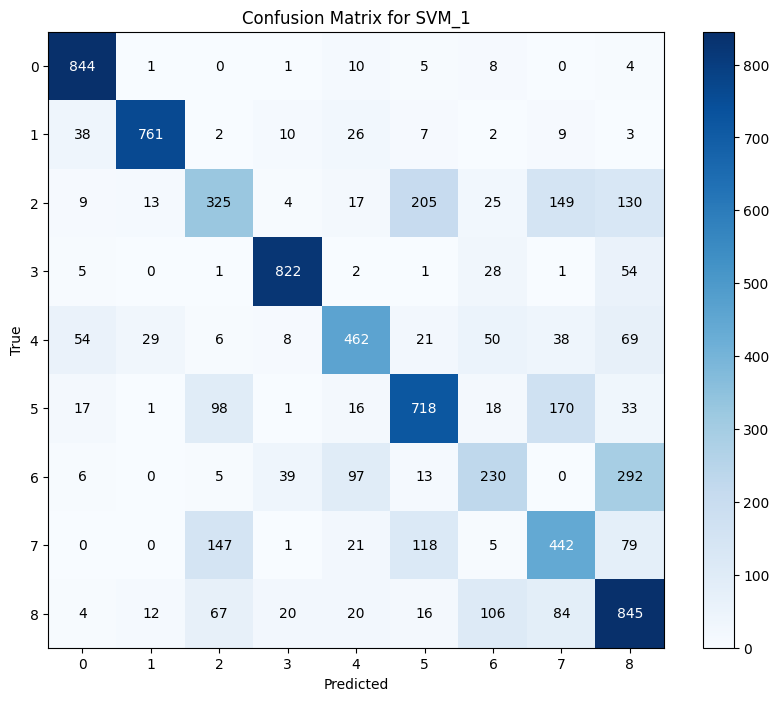


Training SVM_2 with params: {'kernel': 'rbf', 'C': 0.1, 'gamma': 'scale'}
SVM_2 Test Accuracy: 0.6200
Training Time: 13.92s
Inference Time: 9.84s
Number of Support Vectors: 24919

Classification Report for SVM_2:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       873
           1       0.95      0.79      0.86       858
           2       0.48      0.27      0.34       877
           3       0.83      0.79      0.81       914
           4       0.50      0.64      0.56       737
           5       0.58      0.65      0.61      1072
           6       0.28      0.02      0.04       682
           7       0.45      0.48      0.46       813
           8       0.51      0.80      0.62      1174

    accuracy                           0.62      8000
   macro avg       0.60      0.60      0.58      8000
weighted avg       0.60      0.62      0.59      8000



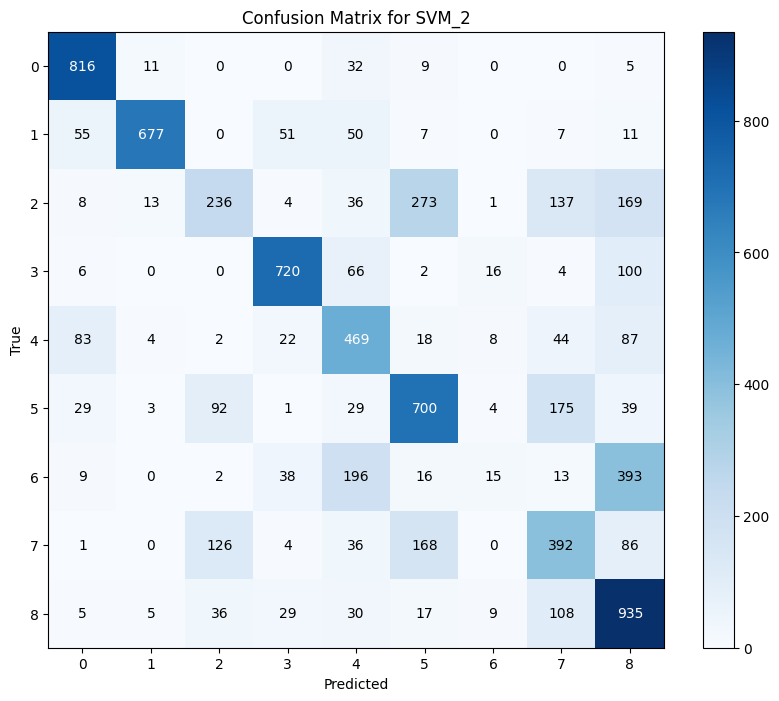


Training SVM_3 with params: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'auto'}
SVM_3 Test Accuracy: 0.4416
Training Time: 52.29s
Inference Time: 11.95s
Number of Support Vectors: 29100

Classification Report for SVM_3:
              precision    recall  f1-score   support

           0       0.92      0.35      0.51       873
           1       1.00      0.82      0.90       858
           2       0.60      0.24      0.34       877
           3       0.94      0.53      0.68       914
           4       0.77      0.09      0.16       737
           5       0.61      0.35      0.45      1072
           6       0.20      0.00      0.00       682
           7       0.60      0.34      0.43       813
           8       0.22      0.95      0.36      1174

    accuracy                           0.44      8000
   macro avg       0.65      0.41      0.43      8000
weighted avg       0.65      0.44      0.44      8000



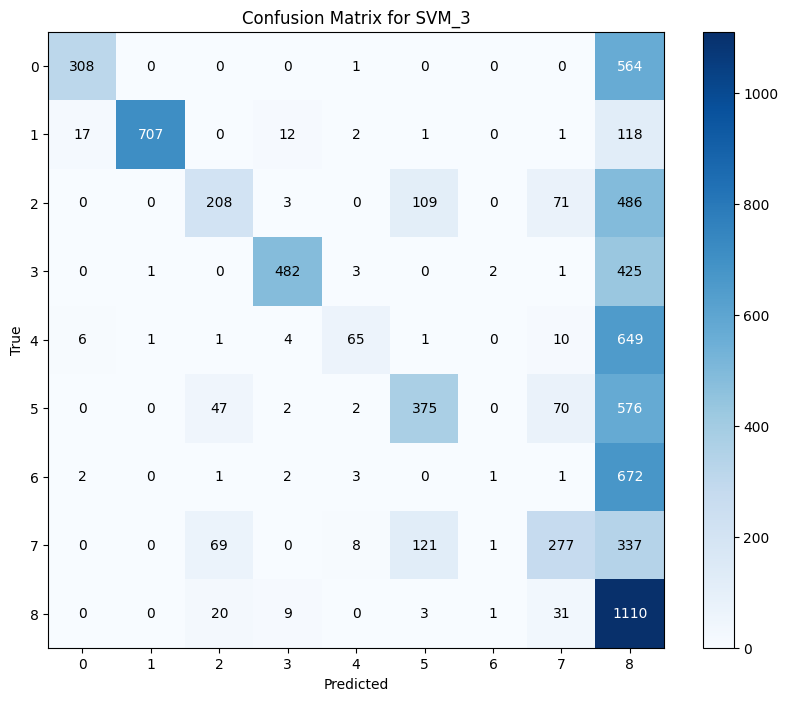


==== Model Comparison ====
Model  Test_Accuracy  Training_Time  Inference_Time  Num_Support_Vectors Kernel    C Gamma  PCA_Components
SVM_1       0.681125       9.339838        7.117216                20206    rbf 10.0 scale              10
SVM_2       0.620000      13.919858        9.841934                24919    rbf  0.1 scale              10
SVM_3       0.441625      52.292192       11.952205                29100    rbf  1.0  auto              10


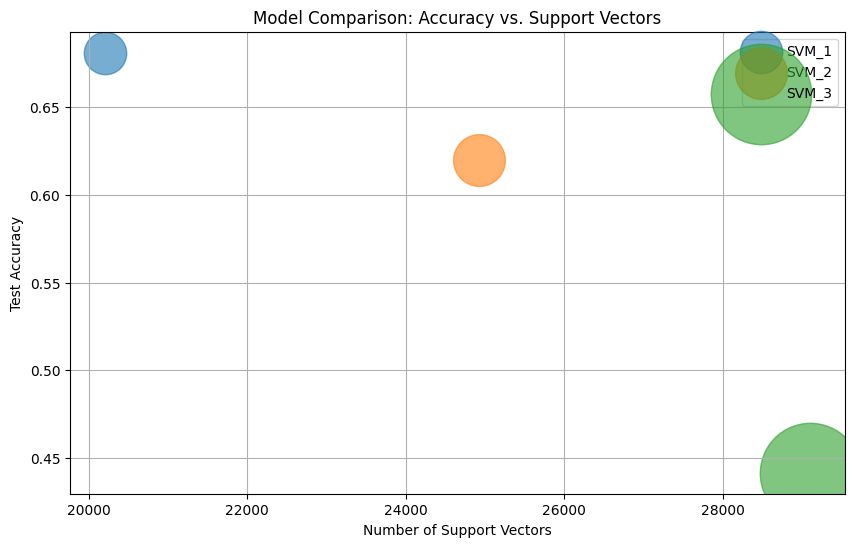

In [ ]:
def compare_pca_svm_models(X_train, y_train, X_test, y_test, best_params_list, 
                          final_n_components=10, verbose=1):
    """
    Args:
    - X_train, y_train: Training data and labels
    - X_test, y_test: Test data and labels
    - best_params_list: List of dictionaries containing hyperparameters for each model
    - final_n_components: Number of PCA components to keep
    - verbose: Verbosity level (0: silent, 1: summary, 2: detailed)

    Returns:
    - results_df: DataFrame containing performance metrics and properties
    """
    results = {
        'Model': [],
        'Test_Accuracy': [],
        'Training_Time': [],
        'Inference_Time': [],
        'Num_Support_Vectors': [],
        'Kernel': [],
        'C': [],
        'Gamma': [],
        'PCA_Components': []
    }

    # Flatten images
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    # Apply StandardScaler
    try:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_flat)
        X_test_scaled = scaler.transform(X_test_flat)
    except Exception as e:
        print(f"Error applying StandardScaler: {str(e)}")
        return pd.DataFrame()

    # Apply PCA
    try:
        pca = PCA(n_components=final_n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
    except Exception as e:
        print(f"Error applying PCA: {str(e)}")
        return pd.DataFrame()

    for idx, params in enumerate(best_params_list):
        model_name = f"SVM_{idx+1}"
        try:
            if verbose >= 1:
                print(f"\nTraining {model_name} with params: {params}")

            # Validate hyperparameters
            if not isinstance(params['C'], (int, float)) or params['C'] <= 0:
                raise ValueError(f"Invalid C: {params['C']}")
            if params['kernel'] not in ['linear', 'rbf', 'poly', 'sigmoid']:
                raise ValueError(f"Invalid kernel: {params['kernel']}")
            if params['gamma'] not in ['scale', 'auto'] and (not isinstance(params['gamma'], (int, float)) or params['gamma'] <= 0):
                raise ValueError(f"Invalid gamma: {params['gamma']}")

            # Initialize SVM
            svm = SVC(
                kernel=params['kernel'],
                C=params['C'],
                gamma=params['gamma'],
                probability=False  # Disable probability for faster inference
            )

            # Train model
            start_train = time.time()
            svm.fit(X_train_pca, y_train)
            training_time = time.time() - start_train

            # Predict and evaluate
            start_inference = time.time()
            y_pred = svm.predict(X_test_pca)
            inference_time = time.time() - start_inference

            test_accuracy = accuracy_score(y_test, y_pred)
            num_support_vectors = len(svm.support_)

            # Store results
            results['Model'].append(model_name)
            results['Test_Accuracy'].append(test_accuracy)
            results['Training_Time'].append(training_time)
            results['Inference_Time'].append(inference_time)
            results['Num_Support_Vectors'].append(num_support_vectors)
            results['Kernel'].append(params['kernel'])
            results['C'].append(params['C'])
            results['Gamma'].append(params['gamma'])
            results['PCA_Components'].append(final_n_components)

            # Detailed output
            if verbose >= 1:
                print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
                print(f"Training Time: {training_time:.2f}s")
                print(f"Inference Time: {inference_time:.2f}s")
                print(f"Number of Support Vectors: {num_support_vectors}")

            if verbose >= 2:
                print(f"\nClassification Report for {model_name}:")
                print(classification_report(y_test, y_pred))

                # Visualize confusion matrix using matplotlib
                cm = confusion_matrix(y_test, y_pred)
                plt.figure(figsize=(10, 8))
                plt.imshow(cm, interpolation='nearest', cmap='Blues')
                plt.colorbar()

                # Add class labels
                classes = np.unique(y_test)
                tick_marks = np.arange(len(classes))
                plt.xticks(tick_marks, classes)
                plt.yticks(tick_marks, classes)

                # Add text annotations for each cell
                for i in range(len(classes)):
                    for j in range(len(classes)):
                        plt.text(j, i, cm[i, j], ha='center', va='center', 
                                 color='white' if cm[i, j] > cm.max() / 2 else 'black')

                plt.title(f'Confusion Matrix for {model_name}')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()

        except Exception as e:
            print(f"Error training model {model_name}: {str(e)}")
            continue

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Summary output
    if verbose >= 1 and not results_df.empty:
        print("\n==== Model Comparison ====")
        print(results_df.to_string(index=False))

        # Visualize comparison using matplotlib
        plt.figure(figsize=(10, 6))
        for idx, row in results_df.iterrows():
            plt.scatter(row['Num_Support_Vectors'], row['Test_Accuracy'], 
                        s=row['Training_Time']*100,  # Scale size for visibility
                        label=row['Model'], alpha=0.6)
        plt.xlabel('Number of Support Vectors')
        plt.ylabel('Test Accuracy')
        plt.title('Model Comparison: Accuracy vs. Support Vectors')
        plt.legend()
        plt.grid(True)
        plt.savefig('svm_comparison_plot.png')
        plt.show()

    return results_df

# Example usage with best parameters from GridSearchCV
best_params_list = [
    {
        'kernel': 'rbf',
        'C': 10,
        'gamma': 'scale'
    },
    {
        'kernel': 'rbf',
        'C': 0.1,
        'gamma': 'scale'
    },
    {
        'kernel': 'rbf',
        'C': 1.0,
        'gamma': 'auto'
    }
]

results_df = compare_pca_svm_models(
    X_train, y_train, X_test, y_test,
    best_params_list=best_params_list,
    final_n_components=10,
    verbose=2
)

# Save results to CSV
if not results_df.empty:
    results_df.to_csv('svm_comparison_results.csv', index=False)

### Fully connected neural network

In [ ]:
def get_model_size(model):
    """Calculate the number of parameters in the model."""
    return model.count_params()

def compare_models(X_train, y_train, X_test, y_test, best_params_list, input_dim, num_classes,
                  pca, scaler, final_training_epochs=50, verbose=True):
    """
    Args:
    - X_train, y_train, X_test, y_test: Preprocessed data
    - best_params_list: List of dictionaries containing best hyperparameters for each model
    - input_dim: Input dimension after PCA
    - num_classes: Number of classes
    - pca: Fitted PCA object
    - scaler: Fitted StandardScaler object
    - final_training_epochs: Epochs for final training
    - verbose: Whether to print progress
    
    Returns:
    - dict: Results containing performance metrics and properties
    """
    results = {
        'Model': [],
        'Test_Accuracy': [],
        'Training_Time': [],
        'Inference_Time': [],
        'Num_Parameters': [],
        'Hidden_Dims': [],
        'Dropout_Rate': [],
        'Learning_Rate': [],
        'Batch_Size': []
    }
    
    # Preprocess data
    X_train_pca = pca.transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
    X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))
    
    # Convert labels to one-hot encoding if needed
    if num_classes > 2:
        y_train_cat = np.eye(num_classes)[y_train]
        y_test_cat = np.eye(num_classes)[y_test]
    else:
        y_train_cat = y_train
        y_test_cat = y_test
    
    for idx, params in enumerate(best_params_list):
        model_name = f"MLP_{idx+1}"
        if verbose:
            print(f"\nTraining {model_name} with params: {params}")
        
        # Create model with best hyperparameters
        model = create_model(
            input_dim=input_dim,
            num_classes=num_classes,
            hidden_dims=params['hidden_dims'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Callbacks
        callbacks = [ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=5,
            verbose=verbose,
            mode='max'
        )]
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_pca, y_train_cat,
            batch_size=params['batch_size'],
            epochs=final_training_epochs,
            validation_data=(X_test_pca, y_test_cat),
            callbacks=callbacks,
            verbose=1 if verbose else 0
        )
        training_time = time.time() - start_train
        
        # Evaluate on test set
        start_inference = time.time()
        y_pred = model.predict(X_test_pca)
        inference_time = time.time() - start_inference
        
        y_pred_classes = np.argmax(y_pred, axis=1) if num_classes > 2 else (y_pred > 0.5).astype(int)
        test_accuracy = accuracy_score(y_test, y_pred_classes)
        
        # Get model size
        num_params = get_model_size(model)
        
        # Store results
        results['Model'].append(model_name)
        results['Test_Accuracy'].append(test_accuracy)
        results['Training_Time'].append(training_time)
        results['Inference_Time'].append(inference_time)
        results['Num_Parameters'].append(num_params)
        results['Hidden_Dims'].append(params['hidden_dims'])
        results['Dropout_Rate'].append(params['dropout_rate'])
        results['Learning_Rate'].append(params['learning_rate'])
        results['Batch_Size'].append(params['batch_size'])
        
        if verbose:
            print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
            print(f"Training Time: {training_time:.2f}s")
            print(f"Inference Time: {inference_time:.2f}s")
            print(f"Number of Parameters: {num_params}")
    
    # Convert results to DataFrame for easy comparison
    results_df = pd.DataFrame(results)
    
    if verbose:
        print("\n==== Model Comparison ====")
        print(results_df.to_string(index=False))
    
    return results_df


# Define multiple sets of hyperparameters
best_params_list = [
    {
        'batch_size': 512,
        'dropout_rate': 0.4186171947440932,
        'hidden_dims': [1024, 512, 256],
        'learning_rate': 0.0036256176345762273
    },
    {
        'batch_size': 256,
        'dropout_rate': 0.3,
        'hidden_dims': [512, 256],
        'learning_rate': 0.001
    },
    {
        'batch_size': 128,
        'dropout_rate': 0.2,
        'hidden_dims': [2048, 1024, 512],
        'learning_rate': 0.0005
    }
]

# Get input_dim and num_classes from the original pipeline
_, pca, scaler, _, _, _ = ht_mlp_pipeline(
    X_train, y_train, X_test, y_test,
    pca_variance=0.95,
    tuning_iterations=10,
    cv_folds=3,
    final_training_epochs=50,
    verbose=True
)

input_dim = pca.n_components_
num_classes = len(np.unique(y_train))

# Compare models
results_df = compare_models(
    X_train, y_train, X_test, y_test,
    best_params_list=best_params_list,
    input_dim=input_dim,
    num_classes=num_classes,
    pca=pca,
    scaler=scaler,
    final_training_epochs=50,
    verbose=True
)

# Save results to CSV for further analysis
results_df.to_csv('model_comparison_results.csv', index=False)

Flattened shapes - Train: (32000, 2352), Test: (8000, 2352)
Standardization complete
PCA reduced dimensions to 343 components
Number of classes: 9
Setting up hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\willi\AppData\Local\Temp\ipykernel_24748\3700583561.py:123: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


[CV] END batch_size=512, dropout_rate=0.4186171947440932, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.0036256176345762273; total time=   2.0s
[CV] END batch_size=512, dropout_rate=0.4186171947440932, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.0036256176345762273; total time=   1.8s
[CV] END batch_size=512, dropout_rate=0.4186171947440932, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.0036256176345762273; total time=   1.8s
[CV] END batch_size=128, dropout_rate=0.1624074561769746, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.00015847101210439104; total time=   5.3s
[CV] END batch_size=128, dropout_rate=0.1624074561769746, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.00015847101210439104; total time=   5.5s
[CV] END batch_size=128, dropout_rate=0.1624074561769746, epochs=10, hidden_dims=[1024, 512, 256], learning_rate=0.00015847101210439104; total time=   5.6s
[CV] END batch_size=512, dropout_rate=0.4464704583099741, epochs=10

### Convolutional neural network

In [ ]:
# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Reshape inputs if needed
if len(X_train.shape) == 3:  # if grayscale
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
else:
    X_train_cnn = X_train
    X_test_cnn = X_test

# CNN model creation
def build_model(learning_rate, dropout_rate, filters, extra_conv_block):
    model = tf.keras.Sequential([
        Conv2D(filters, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001),
               input_shape=X_train_cnn.shape[1:]),
        BatchNormalization(),
        Conv2D(filters, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        
        Conv2D(filters*2, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(filters*2, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate + 0.1),
        
        Conv2D(filters*4, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(filters*4, (3, 3), activation='relu', padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate + 0.2),
        
        *([Conv2D(filters*8, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
           BatchNormalization(),
           MaxPooling2D((2, 2)),
           Dropout(dropout_rate + 0.2)] if extra_conv_block else []),
        
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),
              dtype='float32'),
        BatchNormalization(),
        Dropout(dropout_rate + 0.2),
        
        Dense(9, activation='softmax', dtype='float32')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def get_model_size(model):
    """Calculate the number of parameters in the model."""
    return model.count_params()

def compare_cnn_models(X_train_cnn, y_train, X_test_cnn, y_test, cnn_params_list,
                      final_training_epochs=50, batch_size=256, verbose=True):
    """
    Args:
    - X_train_cnn, y_train, X_test_cnn, y_test: Image data
    - cnn_params_list: List of dictionaries with CNN hyperparameters
    - final_training_epochs: Epochs for final training
    - batch_size: Batch size for training
    - verbose: Whether to print progress
    
    Returns:
    - pd.DataFrame: Results with performance metrics and properties
    """
    results = {
        'Model': [],
        'Test_Accuracy': [],
        'Training_Time': [],
        'Inference_Time': [],
        'Num_Parameters': [],
        'Learning_Rate': [],
        'Dropout_Rate': [],
        'Filters': [],
        'Extra_Conv_Block': []
    }
    
    # Configure datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Train and evaluate CNN models
    for idx, params in enumerate(cnn_params_list):
        model_name = f"CNN_{idx+1}"
        if verbose:
            print(f"\nTraining {model_name} with params: {params}")
        
        model = build_model(
            learning_rate=params['learning_rate'],
            dropout_rate=params['dropout_rate'],
            filters=params['filters'],
            extra_conv_block=params['extra_conv_block']
        )
        
        callbacks = [
            EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
        ]
        
        start_train = time.time()
        history = model.fit(
            train_dataset,
            epochs=final_training_epochs,
            validation_data=test_dataset,
            callbacks=callbacks,
            verbose=1 if verbose else 0
        )
        training_time = time.time() - start_train
        
        start_inference = time.time()
        y_pred = model.predict(X_test_cnn)
        inference_time = time.time() - start_inference
        
        y_pred_classes = np.argmax(y_pred, axis=1)
        test_accuracy = accuracy_score(y_test, y_pred_classes)
        
        num_params = get_model_size(model)
        
        results['Model'].append(model_name)
        results['Test_Accuracy'].append(test_accuracy)
        results['Training_Time'].append(training_time)
        results['Inference_Time'].append(inference_time)
        results['Num_Parameters'].append(num_params)
        results['Learning_Rate'].append(params['learning_rate'])
        results['Dropout_Rate'].append(params['dropout_rate'])
        results['Filters'].append(params['filters'])
        results['Extra_Conv_Block'].append(params['extra_conv_block'])
        
        if verbose:
            print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
            print(f"Training Time: {training_time:.2f}s")
            print(f"Inference Time: {inference_time:.2f}s")
            print(f"Number of Parameters: {num_params}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    if verbose:
        print("\n==== CNN Model Comparison ====")
        print(results_df.to_string(index=False))
    
    return results_df

# CNN hyperparameters
cnn_params_list = [
    {  # Placeholder for best hyperparameters from grid search
        'learning_rate': 0.001,
        'dropout_rate': 0.3,
        'filters': 32,
        'extra_conv_block': True
    },
    {
        'learning_rate': 0.0005,
        'dropout_rate': 0.4,
        'filters': 64,
        'extra_conv_block': False
    },
    {
        'learning_rate': 0.0001,
        'dropout_rate': 0.3,
        'filters': 32,
        'extra_conv_block': False
    }
]

# Compare CNN models
results_df = compare_cnn_models(
    X_train_cnn, y_train, X_test_cnn, y_test,
    cnn_params_list=cnn_params_list,
    final_training_epochs=50,
    batch_size=256,
    verbose=True
)

# Save results
results_df.to_csv('cnn_comparison_results.csv', index=False)


Training CNN_1 with params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'filters': 32, 'extra_conv_block': True}
Epoch 1/50
125/125 [==============================] - 2s 11ms/step - loss: 2.1917 - accuracy: 0.5256 - val_loss: 4.5268 - val_accuracy: 0.1743 - lr: 0.0010
Epoch 2/50
125/125 [==============================] - 1s 10ms/step - loss: 1.5863 - accuracy: 0.6901 - val_loss: 8.1274 - val_accuracy: 0.1077 - lr: 0.0010
Epoch 3/50
125/125 [==============================] - 1s 10ms/step - loss: 1.3693 - accuracy: 0.7509 - val_loss: 6.5412 - val_accuracy: 0.1344 - lr: 0.0010
Epoch 4/50
125/125 [==============================] - 1s 10ms/step - loss: 1.1820 - accuracy: 0.7933 - val_loss: 3.5093 - val_accuracy: 0.2949 - lr: 0.0010
Epoch 5/50
125/125 [==============================] - 1s 10ms/step - loss: 1.0317 - accuracy: 0.8271 - val_loss: 2.3468 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 6/50
125/125 [==============================] - 1s 10ms/step - loss: 0.8873 - accuracy: 0.8572 - v